In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
# Define the model and acquisition parameters
par = {'nx':601,   'dx':0.015, 'ox':0,
       'nz':221,   'dz':0.015, 'oz':0,
       'num_shots':30,    'ds':0.3,   'os':0,  'sz':0,
       'num_receivers_per_shot':300,   'dr':0.03,  'orec':0, 'rz':0,
       'nt':8000,  'dt':0.001,  'ot':0,
       'freq': 5, 'num_sources_per_shot':1, 'num_dims':2,
       'num_batches':30,
        'FWI_itr': 100
      }
device = 'cuda'
velocity_file = '../data/Marm.bin' 

In [3]:
# Load the true model
model_true = (np.fromfile(velocity_file, np.float32)
              .reshape(par['nz'], par['nx']))
m_vmin, m_vmax = np.percentile(model_true, [2,98]) 
# function to get water layer mask
def mask(model,value):
    """
    Return a mask for the model (m) using the (value)
    """
    mask = model > value
    mask = mask.astype(int)
    mask[:21] = 0
    return mask

mask = mask(model_true, 1.5)

In [4]:
# Create initial guess model for inversion by smoothing the true model
model_init = gaussian_filter(model_true, sigma=[10,15])
model_init = model_init * mask
model_init[model_init==0] = 1.5 # km/s
model_init = model_init.astype(np.float32)

In [5]:
# Create folder to save the results
folder_name = f'Results_Marmousi'
if os.path.isdir(folder_name) is False:
    os.makedirs(folder_name)

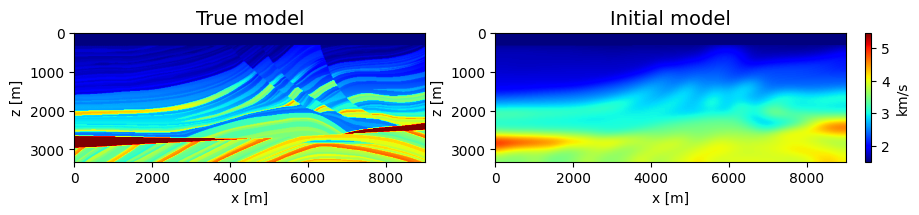

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
im1 = axs[0].imshow(model_true, cmap='jet', vmin=m_vmin, vmax=m_vmax, extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[0].set_title(r'True model', fontsize=14)
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'z [m]')
im2 = axs[1].imshow(model_init, cmap='jet', vmin=m_vmin, vmax=m_vmax, extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[1].set_title(r'Initial model', fontsize=14)
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'z [m]')
fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.21, pad=0.02, label='km/s')
plt.savefig(f'{folder_name}/marmousi', bbox_inches='tight', dpi=300)

In [7]:
exp1 = 'Exp_Marmousi_BB'
exp2 = 'Exp_Marmousi_LBFGS'
exp3 = 'Exp_Marmousi_dm'

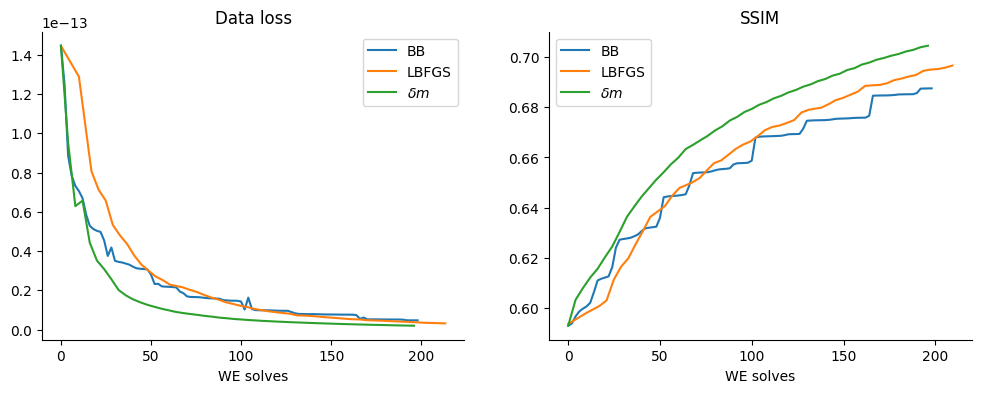

In [8]:
loss_bb = np.load(f'{exp1}/data_loss.npy')
loss_lbfgs = np.load(f'{exp2}/data_loss.npy')
loss_dm = np.load(f'{exp3}/data_loss.npy')
ssim_bb = np.load(f'{exp1}/ssim.npy')
ssim_lbfgs = np.load(f'{exp2}/ssim.npy')
ssim_dm = np.load(f'{exp3}/ssim.npy')
nWE = np.load(f'{exp2}/nWE.npy')

xaxis1 = np.arange(0, 200, 2)
xaxis2 = np.arange(0, 200, 4)
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(xaxis1, loss_bb, label='BB')
axs[0].plot(nWE, loss_lbfgs, label='LBFGS')
axs[0].plot(xaxis2, loss_dm[:50], label=r'$\delta m$')
axs[0].set_title('Data loss')
axs[0].set_xlabel('WE solves')
axs[0].legend()
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].plot(xaxis1, ssim_bb[:-1], label='BB')
axs[1].plot(nWE[:-1], ssim_lbfgs, label='LBFGS')
axs[1].plot(xaxis2, ssim_dm[:50], label=r'$\delta m$')
axs[1].set_title('SSIM')
axs[1].set_xlabel('WE solves')
axs[1].legend()
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'{folder_name}/losses.png',  bbox_inches='tight', dpi=300)

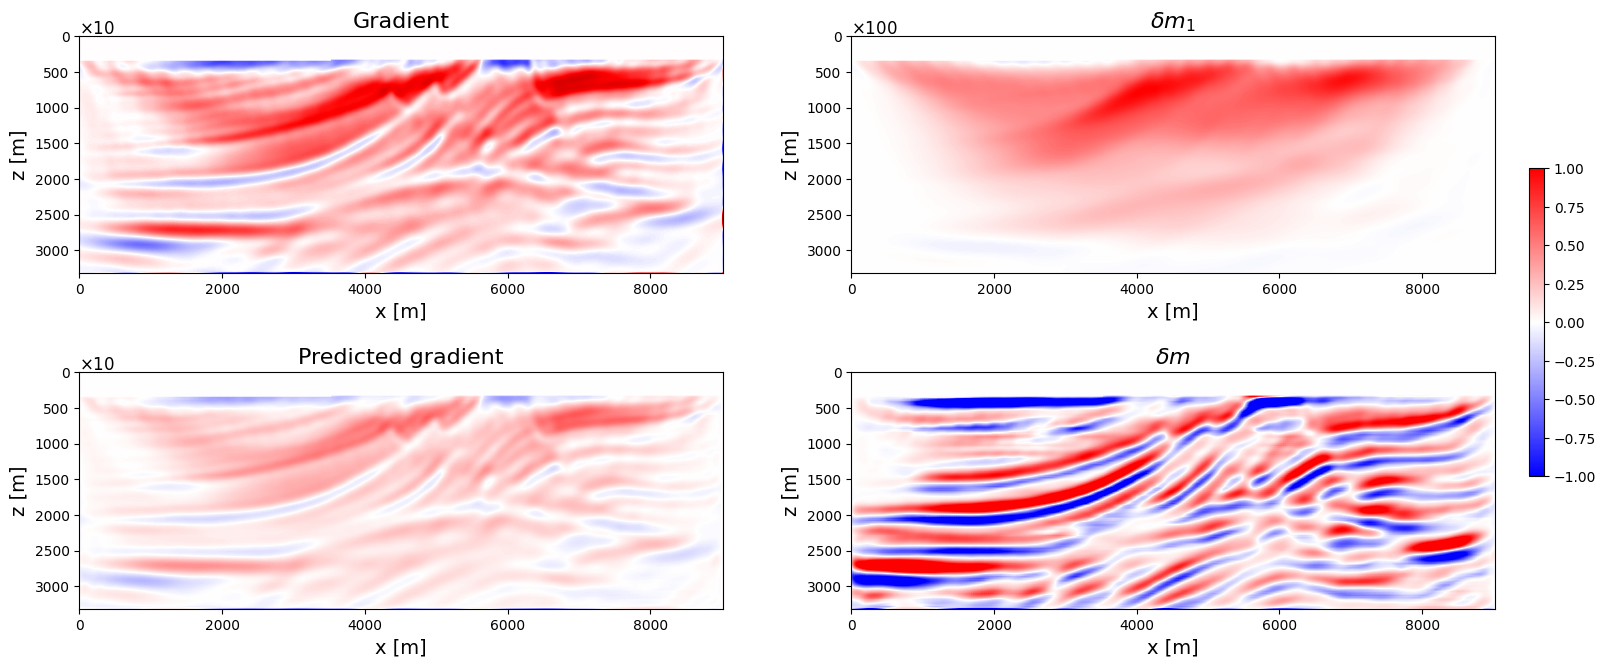

In [9]:
grad = np.load(f'{exp3}/gradient_1.npy')
dm1 = np.load(f'{exp3}/dm1_1.npy')
grad_pred = np.load(f'{exp3}/gradient_pred_1.npy')
dm = np.load(f'{exp3}/dm_1.npy')

font_size = 16
font_size2 = 14
scale = 1
scale_dm = 10
fig, axs = plt.subplots(2, 2, figsize=(22, 8))
im1 = axs[0,0].imshow(10*grad/scale_dm, cmap='seismic', vmin=-scale, vmax=scale, 
                      extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[0,0].set_title(r'Gradient', fontsize=font_size)
axs[0,0].set_xlabel(r'x [m]', fontsize=font_size2)
axs[0,0].set_ylabel(r'z [m]', fontsize=font_size2)
axs[0,0].text(0, 1.07, r'$\times 10$', transform=axs[0,0].transAxes, fontsize=12, verticalalignment='top')
im2 = axs[0,1].imshow(100*dm1/scale_dm, cmap='bwr', vmin=-scale, vmax=scale, 
                      extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[0,1].set_title(r'$\delta m_1$', fontsize=font_size)
axs[0,1].set_xlabel(r'x [m]', fontsize=font_size2)
axs[0,1].set_ylabel(r'z [m]', fontsize=font_size2)
axs[0,1].text(0, 1.07, r'$\times 100$', transform=axs[0,1].transAxes, fontsize=12, verticalalignment='top')
im3 = axs[1,0].imshow(10*grad_pred/scale_dm, cmap='bwr', vmin=-scale, vmax=scale, 
                      extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[1,0].set_title(r'Predicted gradient', fontsize=font_size)
axs[1,0].set_xlabel(r'x [m]', fontsize=font_size2)
axs[1,0].set_ylabel(r'z [m]', fontsize=font_size2)
axs[1,0].text(0, 1.07, r'$\times 10$', transform=axs[1,0].transAxes, fontsize=12, verticalalignment='top')
im4 = axs[1,1].imshow(dm/scale_dm, cmap='bwr', vmin=-scale, vmax=scale, 
                      extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[1,1].set_title(r'$\delta m$', fontsize=font_size)
axs[1,1].set_xlabel(r'x [m]', fontsize=font_size2)
axs[1,1].set_ylabel(r'z [m]', fontsize=font_size2)
fig.colorbar(im4, ax=axs.ravel().tolist(), shrink=0.5, pad=0.02)
plt.savefig(f'{folder_name}/marm_one_iter_0', bbox_inches='tight', dpi=300)

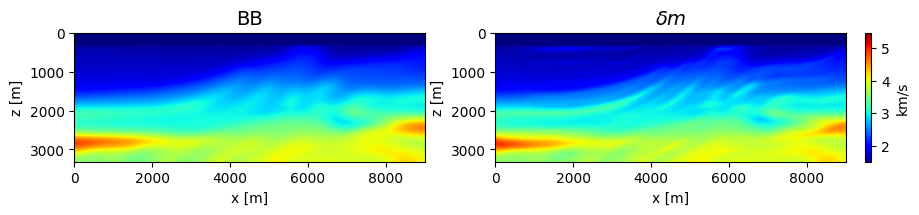

In [10]:
update_bb_1 = np.load(f'{exp1}/update_1.npy')
update_dm_1 = np.load(f'{exp3}/update_1.npy')
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
im1 = axs[0].imshow(update_bb_1, cmap='jet', vmin=m_vmin, vmax=m_vmax, extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[0].set_title(r'BB', fontsize=14)
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'z [m]')
im2 = axs[1].imshow(update_dm_1, cmap='jet', vmin=m_vmin, vmax=m_vmax, extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[1].set_title(r'$\delta m$', fontsize=14)
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'z [m]')
fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.21, pad=0.02, label='km/s')
plt.savefig(f'{folder_name}/model_first_iter', bbox_inches='tight', dpi=300)

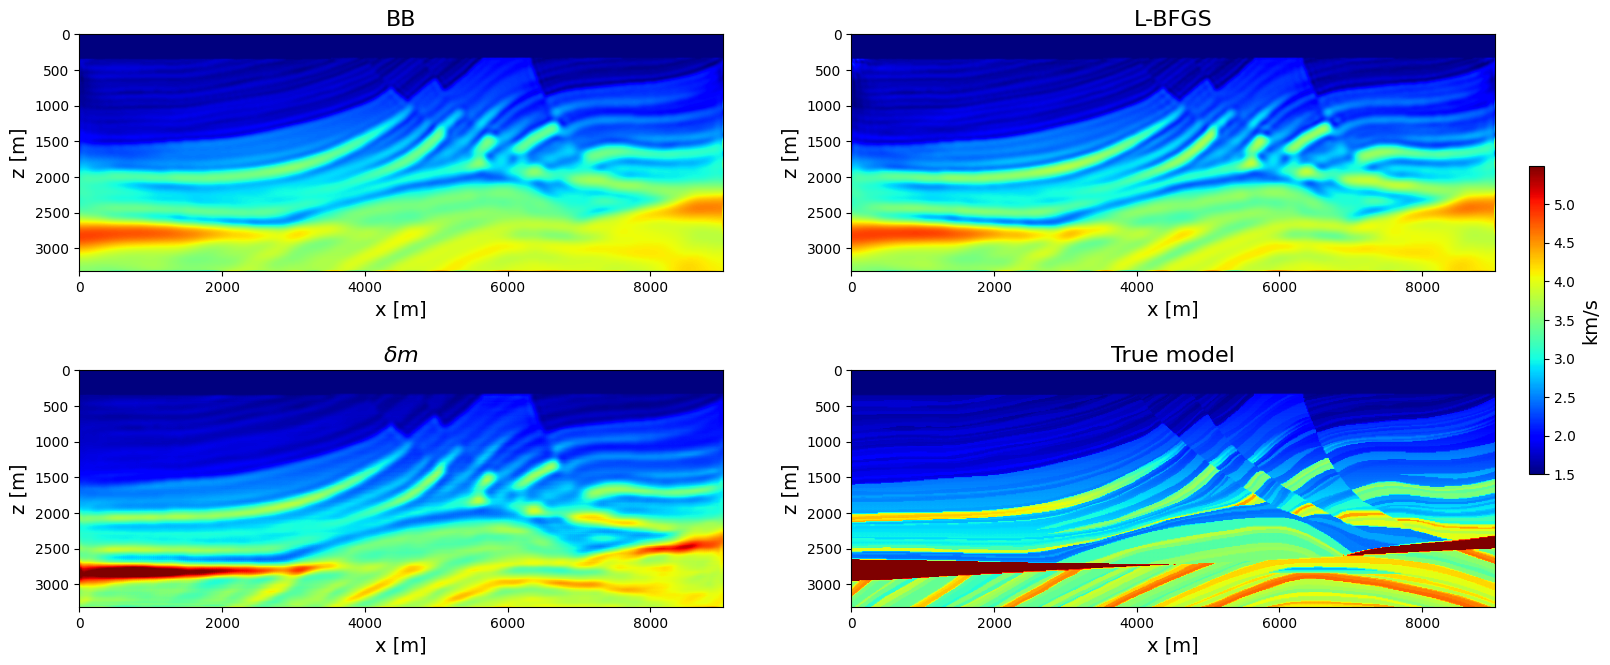

In [11]:
update_bb_100 = np.load(f'{exp1}/update_100.npy')
update_lbfgs = np.load(f'{exp2}/update.npy')
update_dm_50 = np.load(f'{exp3}/update_50.npy')
fig, axs = plt.subplots(2, 2, figsize=(22, 8))
im1 = axs[0,0].imshow(update_bb_100, cmap='jet', vmin=m_vmin, vmax=m_vmax, 
                      extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[0,0].set_title(r'BB', fontsize=font_size)
axs[0,0].set_xlabel(r'x [m]', fontsize=font_size2)
axs[0,0].set_ylabel(r'z [m]', fontsize=font_size2)

im2 = axs[0,1].imshow(update_lbfgs, cmap='jet', vmin=m_vmin, vmax=m_vmax,
                     extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[0,1].set_title(r'L-BFGS', fontsize=font_size)
axs[0,1].set_xlabel(r'x [m]', fontsize=font_size2)
axs[0,1].set_ylabel(r'z [m]', fontsize=font_size2)

im3 = axs[1,0].imshow(update_dm_50, cmap='jet', vmin=m_vmin, vmax=m_vmax, 
                    extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[1,0].set_title(r'$\delta m$', fontsize=font_size)
axs[1,0].set_xlabel(r'x [m]', fontsize=font_size2)
axs[1,0].set_ylabel(r'z [m]', fontsize=font_size2)

im4 = axs[1,1].imshow(model_true, cmap='jet', vmin=m_vmin, vmax=m_vmax, 
                    extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs[1,1].set_title(r'True model', fontsize=font_size)
axs[1,1].set_xlabel(r'x [m]', fontsize=font_size2)
axs[1,1].set_ylabel(r'z [m]', fontsize=font_size2)
fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.5, pad=0.02).set_label(label='km/s',size=14)
plt.savefig(f'{folder_name}/model_comp', bbox_inches='tight', dpi=300)

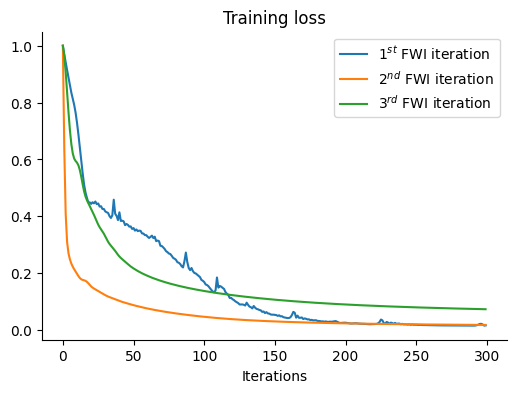

In [12]:
network_loss = np.load(f'{exp3}/network_loss.npy')
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(network_loss[:300]/network_loss[:300].max(), label=r'$1^{st}$ FWI iteration')
ax.plot(network_loss[1000:1300]/network_loss[1000:1300].max(), label=r'$2^{nd}$ FWI iteration')
ax.plot(network_loss[1300:1600]/network_loss[1300:1600].max(), label=r'$3^{rd}$ FWI iteration')
ax.set_title('Training loss')
ax.set_xlabel('Iterations')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.savefig(f'{folder_name}/training_loss.png',  bbox_inches='tight', dpi=300)